In [1]:
#download and import necessary packages

!pip install transformers
!pip install datasets
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertConfig
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments, AutoTokenizer, AutoModelForSequenceClassification, DistilBertTokenizerFast
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
import re
from datasets import load_metric


     |████████████████████████████████| 2.6 MB 4.1 MB/s 
     |████████████████████████████████| 636 kB 58.2 MB/s 
     |████████████████████████████████| 895 kB 65.1 MB/s 
     |████████████████████████████████| 3.3 MB 59.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 264 kB 4.2 MB/s 
     |████████████████████████████████| 243 kB 75.6 MB/s 
     |████████████████████████████████| 118 kB 89.9 MB/s 


In [2]:
#read in manually laballed dataset
dataset = pd.read_csv('/content/drive/MyDrive/opinion_fact_dataset.csv', encoding='cp1252')
dataset = dataset.dropna()

Approach 1). Using textblob to score subjectivity

In [3]:
from textblob import TextBlob
dataset['sentiment'] = dataset['Text'].apply(lambda text: TextBlob(text).sentiment[1])
dataset['y'] = np.where(dataset['Label']== 'Opinion', 1, 0)
dataset['subjectivity'] = np.where(dataset['sentiment'] <= 0.42, 0, 1)

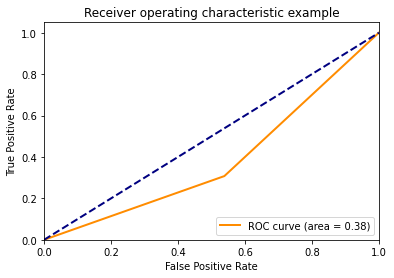

In [6]:
from sklearn.metrics import auc
import matplotlib.pyplot as plt


def plot_roc_curve(fpr, tpr, roc_auc):
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()



neg_fpr, neg_tpr, neg_thresholds = roc_curve(dataset['y'], -dataset['subjectivity'], pos_label= 1)
neg_roc_auc = auc(neg_fpr, neg_tpr)

plot_roc_curve(neg_fpr, neg_tpr, neg_roc_auc)



In [ ]:
#produces a low accuracy
from sklearn import metrics
accuracy_score(dataset['y'], dataset['subjectivity'])

0.6153846153846154

# Counting personal pronouns

In [7]:

def clean(text):
    cleaned_text_1 = re.sub('".*?"', '', text)
    cleaned_text = re.sub(r'\.(?=[^ \W\d])', '. ', cleaned_text_1)
    return cleaned_text

# Now creating a separate column which contains the above function applied to "text" column
dataset["spaces"]= dataset["Text"].apply(lambda x : clean(x) )

In [8]:
pronouns = {'i ', 'I ', 'We ', 'we ', 'Our', 'our ', 'My', 'my ', 'Me', 'me'}

dataset['pronoun_count'] = 0

pronoun_count = 0
counter = 0

for text in dataset['spaces']:
  dataset['pronoun_count'][counter] = pronoun_count
  pronoun_count = 0
  counter += 1

  for word in pronouns:
    pronoun_count = pronoun_count + text.count(word)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [9]:
dataset['y2'] = np.where(dataset['pronoun_count'] > 20, 1, 0)

In [10]:
accuracy_score(dataset['y2'], dataset['y'])

0.7307692307692307

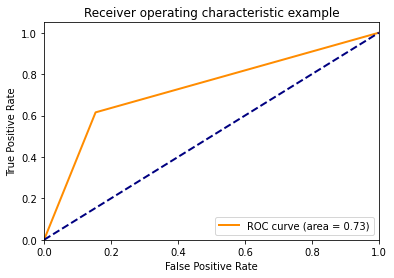

In [12]:
neg_fpr, neg_tpr, neg_thresholds = roc_curve(dataset['y'], -dataset['y2'], pos_label= 0)
neg_roc_auc = auc(neg_fpr, neg_tpr)

plot_roc_curve(neg_fpr, neg_tpr, neg_roc_auc)


# Include personal verbs

In [13]:
pronouns = {'i ', 'I ', 'We ', 'we ', 'Our ', 'our ', 'My ', 'my ', 'Me ', 'me ', 'feel ', 
            'personal ', 'believe ', 'feel ', 'think ', 'emotion'}

dataset['verb_count'] = 0

pronoun_count = 0
counter = 0

for text in dataset['spaces']:
  dataset['verb_count'][counter] = pronoun_count
  pronoun_count = 0
  counter += 1

  for word in pronouns:
    pronoun_count = pronoun_count + text.count(word)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [14]:
dataset['word_count_y'] = np.where(dataset['verb_count'] > 10, 1, 0)
accuracy_score(dataset['word_count_y'], dataset['y'])

0.75

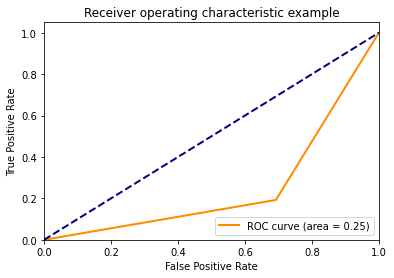

In [18]:
neg_fpr, neg_tpr, neg_thresholds = roc_curve(dataset['y'], -dataset['word_count_y'], pos_label= 1)
neg_roc_auc = auc(neg_fpr, neg_tpr)

plot_roc_curve(neg_fpr, neg_tpr, neg_roc_auc)


# Subjectivity of each sentence

In [19]:

import nltk
from nltk.tokenize import sent_tokenize
nltk.download('punkt')

sentiment_scores = []

def sentence_subjectivity(article, threshold, k):
  sentences = sent_tokenize(article)
  for sent in sentences:
    score = TextBlob(sent).sentiment[1]
    sentiment_scores.append(score)
  count = len([i for i in sentiment_scores if i > threshold])
  if count > k:
    return 1
  else:
    return 0 

dataset['sentence_overall'] = dataset['spaces'].apply(lambda text: sentence_subjectivity(text, 0.99, 10))



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [20]:
accuracy_score(dataset['sentence_overall'], dataset['y'])

0.4423076923076923

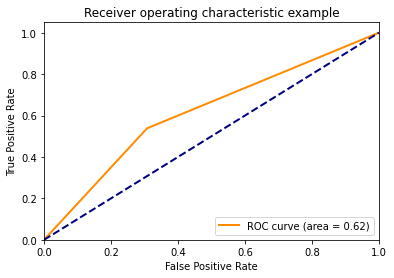

In [22]:
neg_fpr, neg_tpr, neg_thresholds = roc_curve(dataset['y'], -dataset['subjectivity'], pos_label= 0)
neg_roc_auc = auc(neg_fpr, neg_tpr)

plot_roc_curve(neg_fpr, neg_tpr, neg_roc_auc)


# Transformer

In [23]:
!pip install transformers
!pip install datasets

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-base-mnli")

model = AutoModelForSequenceClassification.from_pretrained("microsoft/deberta-base-mnli")

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/728 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/557M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/deberta-base-mnli were not used when initializing DebertaForSequenceClassification: ['config']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.d423bdf2f58dc8b77d5f5d18028d7ae4a72dcfd8f468e81fe979ada957a8c361
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.9.1",
  "vocab_size": 30522
}

loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9a

In [24]:
def transformer(model, tokenizer, text, labels):

    train_texts, test_texts, train_labels, test_labels = train_test_split(text, labels, test_size=.2)
    train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=.2)

    train_encodings = tokenizer(train_texts, truncation=True, padding=True)
    val_encodings = tokenizer(val_texts, truncation=True, padding=True)
    test_encodings = tokenizer(test_texts, truncation=True, padding=True)

    class fake_news_dataset(torch.utils.data.Dataset):
        def __init__(self, encodings, labels):
            self.encodings = encodings
            self.labels = labels

        def __getitem__(self, idx):
           item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
           item['labels'] = torch.tensor(self.labels[idx])
           return item

        def __len__(self):
            return len(self.labels)

    train_dataset = fake_news_dataset(train_encodings, train_labels)
    val_dataset = fake_news_dataset(val_encodings, val_labels)
    test_dataset = fake_news_dataset(test_encodings, val_labels)

    return train_dataset, val_dataset, test_dataset

In [25]:
def clean(text):
    # removing all the characters other than alphabets
    cleaned_text_1= re.sub("[^a-zA-Z]", " ", text)
    cleaned_text_2 = re.sub(r'\W+', ' ', cleaned_text_1)
    # converting text to lower case
    cleaned_text = re.sub("\d+", " ", cleaned_text_2)
    cleaned_text= cleaned_text.lower()

    return cleaned_text

# Now creating a separate column which contains the above function applied to "text" column
dataset['clean'] = dataset["Text"].apply(lambda x : clean(x))

In [26]:
x = dataset['clean'].tolist()
y = dataset['y'].tolist()

In [28]:
tokenizer = AutoTokenizer.from_pretrained('/content/drive/MyDrive/Dissertation/DistilBert/Step_1/50_epochs')
model = AutoModelForSequenceClassification.from_pretrained('/content/drive/MyDrive/Dissertation/DistilBert/Step_1/50_epochs')

In [34]:
train_dataset, val_dataset, test_dataset = transformer(model, tokenizer, x, y)

In [30]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='macro')
    return {
        'f1': f1,
        
        'precision': precision,
        'recall': recall,
        'accuracy': accuracy_score(labels, predictions)
    }

In [32]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=5,              # total number of training epochs
    per_device_train_batch_size=8,  # batch size per device during training
    per_device_eval_batch_size=8,   # batch size for evaluation
    warmup_steps=500,  
    logging_dir='./logs',            # directory for storing logs
    logging_steps=100,
)

#model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,           # evaluation dataset
    compute_metrics = compute_metrics
)

#trainer.train()

In [35]:
trainer.evaluate(test_dataset)

***** Running Evaluation *****
  Num examples = 9
  Batch size = 8


{'eval_accuracy': 0.7777777777777778,
 'eval_f1': 0.75,
 'eval_loss': 1.8094861507415771,
 'eval_precision': 0.75,
 'eval_recall': 0.75,
 'eval_runtime': 0.0639,
 'eval_samples_per_second': 140.893,
 'eval_steps_per_second': 31.31}

In [ ]:
tokenizer.save_pretrained('/content/drive/MyDrive/Dissertation/deBERTa/Step_1/1_epochs/')
model.save_pretrained('/content/drive/MyDrive/Dissertation/deBERTa/Step_1/1_epochs/')

tokenizer config file saved in /content/drive/MyDrive/Dissertation/deBERTa/Step_1/1_epochs/tokenizer_config.json
Special tokens file saved in /content/drive/MyDrive/Dissertation/deBERTa/Step_1/1_epochs/special_tokens_map.json
Configuration saved in /content/drive/MyDrive/Dissertation/deBERTa/Step_1/1_epochs/config.json
Model weights saved in /content/drive/MyDrive/Dissertation/deBERTa/Step_1/1_epochs/pytorch_model.bin


In [37]:
preds = trainer.predict(test_dataset)
preds = preds.predictions.argmax(-1)

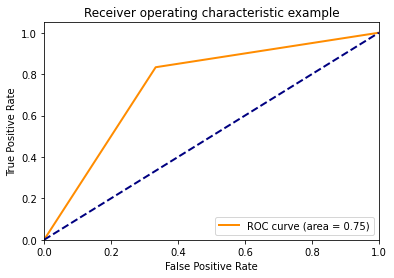

In [40]:
neg_fpr, neg_tpr, neg_thresholds = roc_curve(test_dataset.labels, preds, pos_label= 1)
neg_roc_auc = auc(neg_fpr, neg_tpr)

plot_roc_curve(neg_fpr, neg_tpr, neg_roc_auc)